In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Add Custom scripts
sys.path.append("./scripts/")
from sc_graph_generator.figure_generator import plot_rna_qc, calculate_descriptive, get_per_sample_stats

# Load Packages for analyzing sc-rna-seq data
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    import scanpy as sc
    import muon as mu

# Load the data files

For this we will be loading the .h5ad, which is an [AnnData](https://anndata.readthedocs.io/en/latest/) object.
- This object will have:
    - **.obs:** this contains information about each cell
    - **.var:** this will be the information about each gene
    - **.X:** the will be .var x .obs matrix where .var = genes and .obs is the cells


#### Loading the AnnData object prioduced by BD pipeline.

In [2]:
# Change this to filepath location
adata_file_path = "../data/raw_data/v2-rerun-DL.h5ad"
features_path = "../data/raw_data/v2-rerun-DL_RSEC_MolsPerCell_MEX/features.tsv"

# This will let us know, which are ADT or Gene Expression
features = pd.read_csv(features_path, sep="\t", index_col=0)
features.columns = features.columns.str.replace(" ", "_")
features.index.name = None

# Load Adata
adata = sc.read_h5ad(adata_file_path)
adata.var = adata.var.join(features["Gene_Expression"])

#### Add Meta data to the adata obj

In [3]:
meta_file_path = "../data/meta_data.xlsx"
meta_df = pd.read_excel(meta_file_path)
meta_df = meta_df[meta_df["cartridge"] == "C"]
# Dropping columns that we don't need for the analysis
meta_df.drop(meta_df.columns[4:9], axis=1, inplace=True)
meta_df.rename(columns={"Sample Tags": "Sample_Tag"}, inplace=True)

# Combine the Meta data with the Adata object
df = pd.merge(
    left=adata.obs, 
    right=meta_df, 
    on="Sample_Tag", 
    how="left",
)

df.set_index(adata.obs.index, inplace=True)
adata.obs = df

### Split Gene Expression Data and ADT data

In [4]:
gex_bool = adata.var["Gene_Expression"] == "Gene Expression"
adt_bool = adata.var["Gene_Expression"] == "Antibody Capture"
# Split them
adata_gex = adata[:, gex_bool].copy()
adata_adt = adata[:, adt_bool].copy()

In [5]:
print(f"There were {adata_gex.n_obs} cells and {adata_gex.n_vars} of genes.")
print(f"There were {adata_adt.n_vars} ADT")

There were 153518 cells and 37545 of genes.
There were 22 ADT


## QC Steps for RNA

#### calculate the QC covariates or metric.
- Mitochondrial Genes
- Ribosomal Genes
- Hemoglobin Genes

In [6]:
# mitochondrial genes
adata_gex.var["mt"] = adata_gex.var_names.str.startswith("MT-")
# ribosomal genes
adata_gex.var["ribo"] = adata_gex.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gex.var["hb"] = adata_gex.var_names.str.contains(("^HB[^(P)]"))

sc.pp.calculate_qc_metrics(
    adata_gex, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Plot Covarities

### Setting Thresholds for Covarities

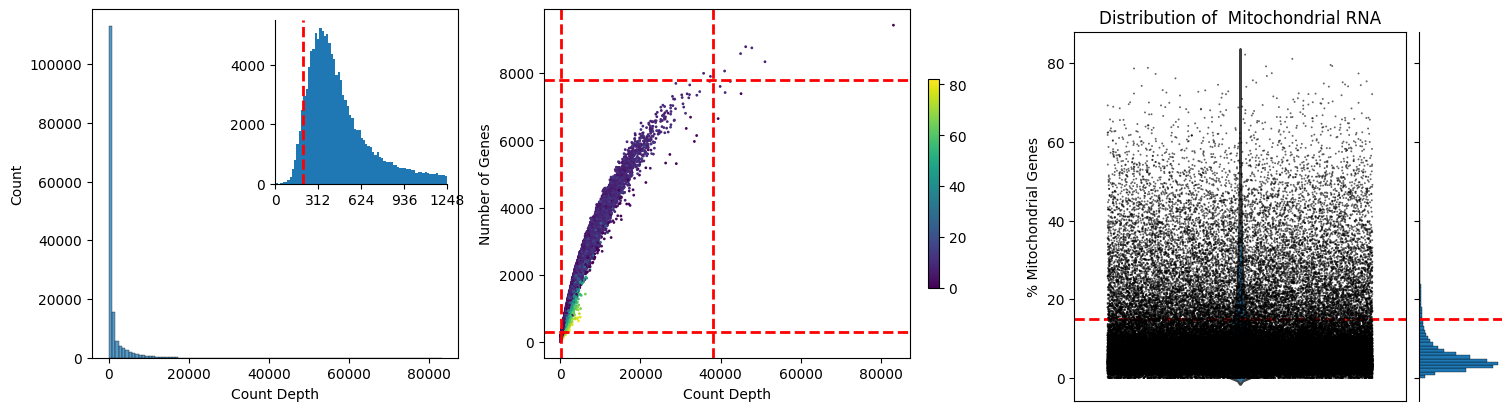

In [16]:
# Set adjust these accordingly.
outliers = {
    "pct_counts_mt": 15,
    "total_counts_low": 200,
    "total_counts_high": 38000,
    "n_genes_by_counts_low": 300,
    "n_genes_by_counts_high": 7800
}



fig = plot_rna_qc(adata_gex, 
                  # show_jitter=False, 
                  zoom=(0, 1250), 
                  zoom_bins=5000
                 )

axs = fig.get_axes()

for item in axs[0].get_children():
    if isinstance(item, plt.Axes):
        item.axvline(x=outliers["total_counts_low"], color="red", ls="--", lw=2)

# cut off for sequencing
axs[1].axvline(x=outliers["total_counts_low"], color="red", ls="--", lw=2)
axs[1].axvline(x=outliers["total_counts_high"], color="red", ls="--", lw=2)


# Cut off for n_genes
axs[1].axhline(y=outliers["n_genes_by_counts_low"], color="red", ls="--", lw=2)
axs[1].axhline(y=outliers["n_genes_by_counts_high"], color="red", ls="--", lw=2)


# Set to zoom in
# axs[1].set_xlim(0, 625)

# Cut off for PCT 
axs[3].axhline(y=outliers["pct_counts_mt"], color="red", ls="--", lw=2)
axs[4].axhline(y=outliers["pct_counts_mt"], color="red", ls="--", lw=2)

In [17]:
calculate_descriptive(adata=adata_gex, is_rhapsody=True, sample_name="121c", mt_threshold=outliers["pct_counts_mt"])

,121c
Cell Count,153518
Number Reads,194962198
Median Genes Per Cell,325.00
% MT Per Cell,4.68
Cells Pass 15% Threshold,89.57%
Number of Multi Tagged Cells,12844
% Multi Tagged Cells,8.37%
Number of Undetermined Tags,80255
% Undetermined Cells Tagged,52.28%


In [18]:
get_per_sample_stats(adata=adata_gex, mt_threshold=outliers["pct_counts_mt"], samples_col="Sample_Tag")

,Mean % MT Per Cell,Mean # Reads Per Cell,Mean # Gene Per Cell,Cells Pass 15% Threshold,Cell Count,Read Depth
Sample_Tag,,,,,,
SampleTag01_hs,9.60,"1,050.14",618.04,79.68%,4807,5048009
SampleTag02_hs,12.13,"1,755.43",809.04,75.92%,4153,7290307
SampleTag03_hs,12.01,"2,051.18",960.55,75.58%,4665,9568744
SampleTag04_hs,7.74,"1,509.71",754.56,90.53%,4617,6970313
SampleTag05_hs,11.88,"1,142.43",652.61,71.08%,3513,4013365
SampleTag06_hs,13.60,"2,124.13",929.80,72.77%,5568,11827174
SampleTag07_hs,10.27,"1,903.57",924.66,80.98%,6757,12862422
SampleTag08_hs,10.26,"1,698.19",840.77,79.08%,5076,8620010
SampleTag09_hs,8.94,"1,677.46",910.67,86.58%,4656,7810261


# Remove Unknown, Multiplets and poor quality reads based on covarities

### Remove Dead or Dying Cells

In [19]:
filter_mt = adata_gex.obs["pct_counts_mt"] <= outliers["pct_counts_mt"]
filter_counts = adata_gex.obs["total_counts"].between(outliers["total_counts_low"], outliers["total_counts_high"])
filter_n_genes =  adata_gex.obs["n_genes_by_counts"].between(outliers["n_genes_by_counts_low"], outliers["n_genes_by_counts_high"])

# Filter cells on all three covarities
# adata_gex = adata_gex[filter_mt &  filter_counts & filter_n_genes]
health_bool = (filter_counts | filter_n_genes) & filter_mt
pct_pass = health_bool.sum() / len(adata_gex) 
print(f"{round(pct_pass, 4) * 100}% ({health_bool.sum()} total cells) Living Cells.")

85.37% (131064 total cells) Living Cells.


In [20]:
adata_gex = adata_gex[health_bool, ]

#### Removing Multiplets and Singlets

In [21]:
unkown_multi_cells = adata_gex.obs["Sample_Tag"].isin(["Undetermined", "Multiplet"])
adata_gex = adata_gex[~unkown_multi_cells,]
print(f"Removed {unkown_multi_cells.sum()} cells.")
print(f"{adata_gex.n_obs} cells remain.")

Removed 83972 cells.
47092 cells remain.


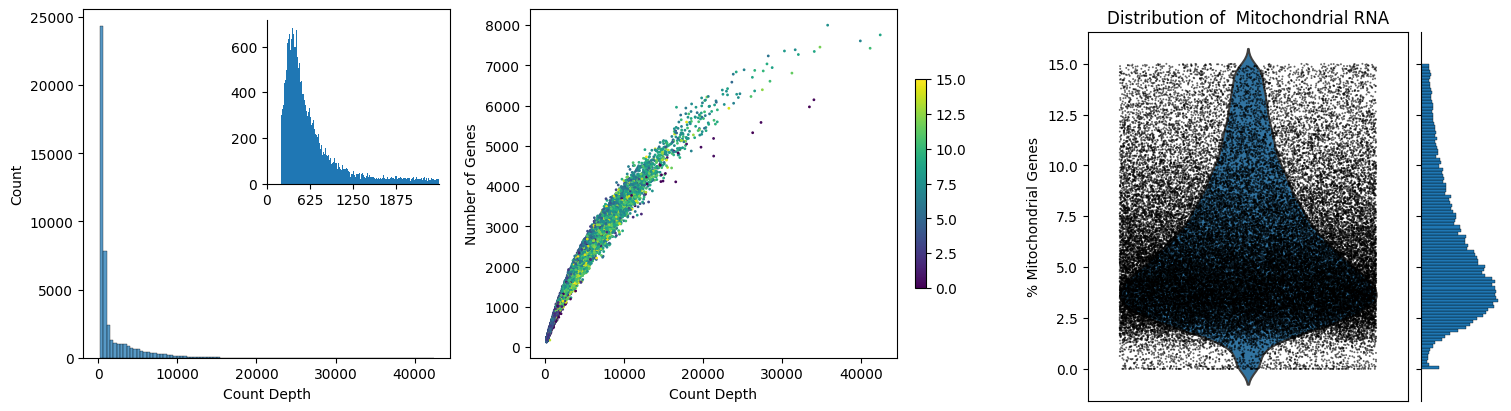

In [22]:
fig = plot_rna_qc(adata_gex, 
                  # show_jitter=False, 
                  zoom=(0, 2500), 
                  zoom_bins=5000
                 )

In [23]:
print(f"Total remaining cells {adata_gex.n_obs}")

Total remaining cells 47092


## Remove Doublets
To remove doublets run each code block in the R markdown `../r_notebooks/dbltFinder.Rmd`. 
- Before running the R markdown be sure to run the next line of code titled, Export Sparse Matrix For R.

In [32]:
import os
import scipy.io as sio 

### Export Sparse Matrix for R

In [34]:
mtx = adata_gex.X.T

if "tmp" not in os.listdir("../data/"):
    os.mkdir("../data/tmp")
    
with open("../data/tmp/barcodes.tsv", "w") as f:
    barcodes = "\n".join(list(adata_gex.obs_names))
    f.writelines(barcodes)

with open("../data/tmp/features.tsv", "w") as f:
    var_names = "\n".join(list(adata_gex.var_names))
    f.writelines(var_names)
    
sio.mmwrite("../data/tmp/sparse_matrix.mtx", mtx)

### Load Doublet Detection Results

In [37]:
# Load doublet resutls and replce "." with "_" in the column names.
dblt_finders = pd.read_csv("../data/tmp/dblt_scores.csv", index_col=0)
dblt_finders.columns = dblt_finders.columns.str.replace(".", "_")

# This allows us to see float points at higher precision
pd.options.display.float_format = None

# Need to convert index to str
dblt_finders.index = dblt_finders.index.astype(str)
adata_gex.obs.index = adata_gex.obs.index.astype(str)
adata_gex.obs = adata_gex.obs.join(dblt_finders)

In [40]:
singlets, doublets = adata_gex.obs.doublet_class.value_counts()
pct_dblts = round(doublets / (singlets + doublets), 4) * 100
print(f"The pct of potential doubles {pct_dblts}% ({doublets} total) found.")

The pct of potential doubles 24.38% (11480 total) found.


## Save QC Results

In [48]:
filename = "121c_quality_control.h5ad"

if "qc_data" not in os.listdir("../data"):
    os.mkdir("../data/qc_data")

save_file_path = f"../data/qc_data/{filename}"

adata_gex.obs.day = adata_gex.obs.day.astype(str)
adata_gex.obs["date"] = adata_gex.obs["date"].astype(str)
adata_gex.write(save_file_path)

# Save ADT in Raw Folder

In [47]:
filename = "121c_ADT_raw.h5ad"
save_file_path = f"../data/raw_data/{filename}"

adata_adt.obs.day = adata_adt.obs.day.astype(str)
adata_adt.obs["date"] = adata_adt.obs["date"].astype(str)
adata_adt.write(save_file_path)